<a href="https://colab.research.google.com/github/prabal5ghosh/Deep-Learning-summer-school-2025-university-of-cote-d-Azur/blob/main/DistillationLab_SUJET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img width=60% src="http://www.i3s.unice.fr/~lingrand/efeliaUnica.png"><br/><br/>
<font size=+3><b>Distillation in neural networks</b></font><br/><br/>
<font size=+1>Célia D'cruz, Rémy Sun, Frédéric Precioso and Diane Lingrand<br/>
Deep Learning School<br/>
    2025 - June/July<br/></font>
    <img width=14% src="http://www.i3s.unice.fr/~lingrand/cc-long.png">
    </center>

<font size=+2> This lab is based on the pytorch lab on [Knowledge Distillation Tutorial by Alexandros Chariton](https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html)</font>


Knowledge distillation is a technique that enables knowledge transfer
from large, computationally expensive models to smaller ones without
losing validity. This allows for deployment on less powerful hardware,
making evaluation faster and more efficient.

In this tutorial, we will run a number of experiments focused at
improving the accuracy of a lightweight neural network, using a more
powerful network as a teacher. The computational cost and the speed of
the lightweight network will remain unaffected, our intervention only
focuses on its weights, not on its forward pass. Applications of this
technology can be found in devices such as drones or mobile phones. In
this tutorial, we do not use any external packages as everything we need
is available in `torch` and `torchvision`.

In this tutorial, you will learn:

-   How to modify model classes to extract hidden representations and
    use them for further calculations
-   How to modify regular train loops in PyTorch to include additional
    losses on top of, for example, cross-entropy for classification
-   How to improve the performance of lightweight models by using more
    complex models as teachers

Prerequisites
=============

-   1 GPU, 4GB of memory
-   PyTorch v2.0 or later
-   CIFAR-10 dataset (downloaded by the script and saved in a directory
    called `/data`)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# making the code device agnostic
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='cuda')

Loading CIFAR-10
================

CIFAR-10 is a popular image dataset with ten classes. Our objective is
to predict one of the following classes for each input image.

![Example of CIFAR-10images](https://pytorch.org/tutorials//../_static/img/cifar10.png)

The input images are RGB, so they have 3 channels and are 32x32 pixels.
Basically, each image is described by 3 x 32 x 32 = 3072 numbers ranging
from 0 to 255. A common practice in neural networks is to normalize the
input, which is done for multiple reasons, including avoiding saturation
in commonly used activation functions and increasing numerical
stability. Our normalization process consists of subtracting the mean
and dividing by the standard deviation along each channel. The tensors
\"mean=\[0.485, 0.456, 0.406\]\" and \"std=\[0.229, 0.224, 0.225\]\"
were already computed, and they represent the mean and standard
deviation of each channel in the predefined subset of CIFAR-10 intended
to be the training set. Notice how we use these values for the test set
as well, without recomputing the mean and standard deviation from
scratch. This is because the network was trained on features produced by
subtracting and dividing the numbers above, and we want to maintain
consistency. Furthermore, in real life, we would not be able to compute
the mean and standard deviation of the test set since, under our
assumptions, this data would not be accessible at that point.

As a closing point, we often refer to this held-out set as the
validation set, and we use a separate set, called the test set, after
optimizing a model\'s performance on the validation set. This is done to
avoid selecting a model based on the greedy and biased optimization of a
single metric.


In [3]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [4]:
from torch.utils.data import random_split
train_dataset, val_dataset = random_split(train_dataset, [40000, 10000], torch.Generator().manual_seed(42))

<div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>NOTE:</strong></div>

<div style="background-color: #f3f4f7; padding-left: 10px; padding-top: 10px; padding-bottom: 10px; padding-right: 10px">

<p>This section is for CPU users only who are interested in quick results. Use this option only if you're interested in a small scale experiment. Keep in mind the code should run fairly quickly using any GPU. Select only the first <code>num_images_to_keep</code> images from the train/test dataset<pre><code>#from torch.utils.data import Subset</p>
<h1>num_images_to_keep = 2000</h1>
<h1>train_dataset = Subset(train_dataset, range(min(num_images_to_keep, 50_000)))</h1>
<h1>test_dataset = Subset(test_dataset, range(min(num_images_to_keep, 10_000)))</code></pre></h1>
```

</div>



In [5]:
#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

🤔 <b><font color='purple'>Question:</font></b> How many samples are there in the train and test set? Print one sample from the train set: what is the shape of the input image, what is its associated label (class)?

In [40]:
print("train set shape", len(train_dataset))
print("test set shape", len(test_dataset))


train set shape 40000
test set shape 10000


In [41]:

one_sample_input, one_sample_target = train_dataset[0]
print("one image =", one_sample_input)
print("shape of the image =", one_sample_input.shape)
print("image label =", one_sample_target)

one image = tensor([[[-1.0733, -0.9020, -0.7822,  ..., -0.7822, -0.9020, -1.1247],
         [-0.1657, -0.2513, -0.5253,  ..., -0.7137, -0.9020, -1.0904],
         [-0.7479, -0.9877, -1.2788,  ..., -0.5082, -0.5424, -0.7308],
         ...,
         [-2.0494, -2.0152, -2.1179,  ..., -0.1828, -0.3369, -0.1828],
         [-1.9809, -1.8782, -2.0152,  ..., -0.0972, -0.4568, -0.5767],
         [-1.4672, -1.4672, -1.6213,  ..., -0.4739, -0.6794, -0.5596]],

        [[-1.0378, -0.9503, -0.8102,  ..., -0.8978, -1.0203, -1.2129],
         [-0.1275, -0.2850, -0.5126,  ..., -0.7577, -0.9678, -1.1429],
         [-0.7052, -0.9853, -1.1779,  ..., -0.4951, -0.5826, -0.7752],
         ...,
         [-1.7206, -1.8081, -1.7206,  ..., -0.7052, -1.0553, -1.1779],
         [-1.8256, -1.7731, -1.8081,  ..., -0.6877, -1.0028, -1.2479],
         [-1.5280, -1.5980, -1.7206,  ..., -1.1429, -1.3004, -1.1779]],

        [[-0.8284, -0.7587, -0.6541,  ..., -0.9156, -0.9678, -1.1421],
         [ 0.1476,  0.0256, -0.28

In [42]:
# your work
train_loader_iter = iter(train_loader)
train_images, train_labels = next(train_loader_iter)

In [43]:
len(train_dataset)

40000

In [44]:
train_images

tensor([[[[ 1.3413,  1.3413,  1.3242,  ...,  1.3584,  1.2043,  1.2899],
          [ 1.2214,  1.1872,  1.2043,  ...,  0.9988,  0.9132,  1.0159],
          [ 1.0159,  0.9646,  0.9817,  ...,  0.7762,  0.7762,  0.9303],
          ...,
          [-1.5699, -1.4158, -1.0390,  ..., -1.7069, -1.7412, -1.7583],
          [-1.5185, -0.9363,  0.0912,  ..., -1.6213, -1.7754, -1.7412],
          [-1.5699, -1.4843, -1.2445,  ..., -1.7412, -1.7754, -1.7240]],

         [[ 1.9209,  1.9209,  1.8859,  ...,  1.9559,  1.8333,  1.8859],
          [ 1.8333,  1.8158,  1.8508,  ...,  1.7808,  1.7108,  1.7108],
          [ 1.7458,  1.7283,  1.7458,  ...,  1.6933,  1.6933,  1.6933],
          ...,
          [-0.7227, -0.6176, -0.3901,  ..., -0.3550, -0.3901, -0.4076],
          [-0.6352, -0.1975,  0.6604,  ..., -0.3200, -0.3200, -0.5301],
          [-0.7752, -0.7927, -0.6527,  ..., -0.8102, -0.6176, -0.7227]],

         [[ 2.6400,  2.5703,  2.6051,  ...,  2.6226,  2.6051,  2.6226],
          [ 2.5180,  2.4134,  

In [45]:
train_images.shape

torch.Size([128, 3, 32, 32])

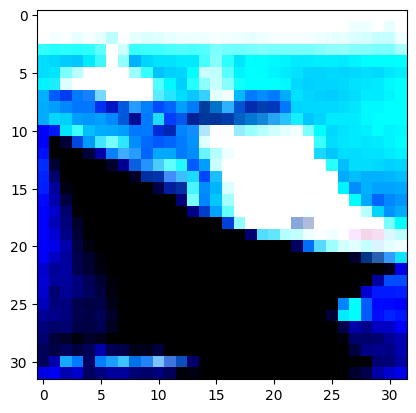

In [46]:
plt.imshow(train_images[0].permute(1, 2, 0))

In [47]:
test_loader_iter = iter(test_loader)
test_images, test_labels = next(test_loader_iter)

In [49]:
test_images.shape

torch.Size([128, 3, 32, 32])

In [50]:
test_images[0].shape

torch.Size([3, 32, 32])

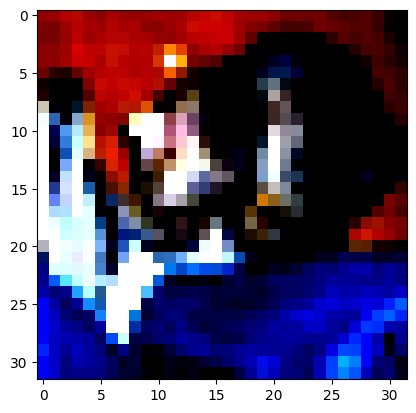

In [22]:
plt.imshow(test_images[0].permute(1, 2, 0))

We plot the distribution of the train, valid and test set.

In [28]:
def plot_class_distribution(y_train, y_val, y_test):
    number_of_classes = len(np.unique(y_train))

    fig, ax = plt.subplots(layout="constrained")
    for y, name, offset in zip([y_train, y_val, y_test], ["Train", "Val", "Test"], [-0.2, 0, 0.2]):
        rects = ax.bar(np.arange(number_of_classes)+offset, np.bincount(y), 0.2, label=name)
        ax.bar_label(rects)

    ax.set_ylabel("Number of samples")
    ax.set_xlabel("Class number")
    ax.set_title("Distribution of classes")
    ax.set_xticks(np.arange(number_of_classes))
    ax.legend()
    plt.show()

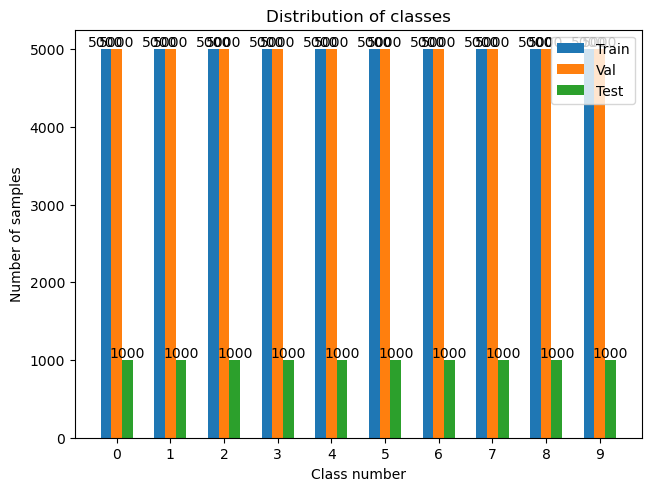

In [ ]:
plot_class_distribution(train_dataset.dataset.targets, val_dataset.dataset.targets, test_dataset.targets)

Defining model classes and utility functions
============================================

Next, we need to define our model classes. Several user-defined
parameters need to be set here. We use two different architectures,
keeping the number of filters fixed across our experiments to ensure
fair comparisons. Both architectures are Convolutional Neural Networks
(CNNs) with a different number of convolutional layers that serve as
feature extractors, followed by a classifier with 10 classes. The number
of filters and neurons is smaller for the students.


In [29]:
# Deeper neural network class to be used as teacher:
class DeepNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Lightweight neural network class to be used as student:
class LightNN(nn.Module):
    def __init__(self, num_classes=10):
        super(LightNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

We employ 2 functions to help us produce and evaluate the results on our
original classification task. One function is called `train` and takes
the following arguments:

-   `model`: A model instance to train (update its weights) via this
    function.
-   `train_loader`: We defined our `train_loader` above, and its job is
    to feed the data into the model.
-   `epochs`: How many times we loop over the dataset.
-   `learning_rate`: The learning rate determines how large our steps
    towards convergence should be. Too large or too small steps can be
    detrimental.
-   `device`: Determines the device to run the workload on. Can be
    either CPU or GPU depending on availability.

Our test function is similar, but it will be invoked with `test_loader`
to load images from the test set.

![Train both networks with Cross-Entropy. The student will be used as a
baseline:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/ce_only.png)


In [30]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_val_loss = 0.0
        for inputs, labels in val_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
              outputs = model(inputs)

              # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
              # labels: The actual labels of the images. Vector of dimensionality batch_size
              loss = criterion(outputs, labels)

            running_val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)},  Val_Loss: {running_val_loss / len(val_loader)}")

def test(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

🤔 <b><font color='purple'>Question:</font></b> Add the display of the train and validation accuracies at the end of the training loop.

In [ ]:
# your work

# Training the teacher

Start by training the teacher network using cross-entropy:


In [51]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

Epoch 1/10, Loss: 1.4561911971805195,  Val_Loss: 1.1948809510544887
Epoch 2/10, Loss: 0.9847455276087069,  Val_Loss: 0.9154411901401568
Epoch 3/10, Loss: 0.7687419260652683,  Val_Loss: 0.8016349726085421
Epoch 4/10, Loss: 0.6142794479386875,  Val_Loss: 0.7648729915860333
Epoch 5/10, Loss: 0.46846803622885635,  Val_Loss: 0.7939900552170186
Epoch 6/10, Loss: 0.34880500293958683,  Val_Loss: 0.8861446207082724
Epoch 7/10, Loss: 0.24613572876103007,  Val_Loss: 0.9646181094495556
Epoch 8/10, Loss: 0.17579482424373444,  Val_Loss: 1.1543857451481154
Epoch 9/10, Loss: 0.14229806723257604,  Val_Loss: 1.2670872445347943
Epoch 10/10, Loss: 0.1190516323374864,  Val_Loss: 1.3403417505795443
Test Accuracy: 72.83%


As you can observe, while the model clearly improves its training loss throughout training, the validation loss stops improving very fast and in fact starts deteriorating quite early. This phenomenon is called overfitting: the model finds improvements that specifically fit the training dataset but the not the overall distribution of interest.

A common way explain such a phenomenon comes from comparing the amount of training data available to the capacity of the model to fit complex functions. If we are dealing with a fairly small amount of training data, even slightly complex models like our DeepNN are going to quickly overfit to it. Unfortunately, acquiring more data is typically difficult.

One solution to this problem is to make it harder to overfit to the limited amount of training data available by creating artificial samples from the data we do have: this is called data augmentation. Thankfully for us, pytorch natively supports a wide catalog of transformation functions through its transforms API.

🤔 <b><font color='purple'>Question:</font></b> Modify the training dataset transform function to incorporate classical Data Augmentation techniques like Random Cropping and Flipping. You can then retrain the model to see how much this improves the training procedure.

In [54]:
# Add the random data augmentation that you want for training.
train_transforms_cifar = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
train_dataset, val_dataset = random_split(train_dataset, [40000, 10000], torch.Generator().manual_seed(42))
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms_cifar)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

In [ ]:
torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

Epoch 1/10, Loss: 1.5692465088861374,  Val_Loss: 1.221982691106917
Epoch 2/10, Loss: 1.1661315074052347,  Val_Loss: 0.9518082556845266


If you want to go further, there are stronger families of data augmentations such as strong data augmentations (similar to what you have been playing with but using much stronger perturbation intensities) and mixing sample data augmentation (where multiple samples are mixed and a hybrid label is predicted).

One classical example of a mixing augmentation is the seminal MixUp framework where two images $x_1$ and $x_2$ are interpolated into a mixed sample $x = \lambda x_1 + (1-\lambda) x_2$ with typically ratio $\lambda \sim \beta(\alpha=1, \alpha=1)$. The model is trained to then predict a mixed target $y = \lambda y_1 + (1-\lambda) y_2$. This can typically be easily implemented through a weighted loss.

🤔 <b><font color='purple'>Question:</font></b> Rewrite the training function to accommodate a mixup procedure. As the model we train is not very big, you can try to only perform mixup a fraction of the time (e.g. 1 time out of 10).

In [ ]:
def train(model, train_loader, val_loader, epochs, learning_rate, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            # Implement Mixup mixing here!
            # YOUR WORK


            optimizer.zero_grad()
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size

             # HERE ALSO

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_val_loss = 0.0
        for inputs, labels in val_loader:
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.no_grad():
              outputs = model(inputs)

              # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
              # labels: The actual labels of the images. Vector of dimensionality batch_size
              loss = criterion(outputs, labels)

            running_val_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)},  Val_Loss: {running_val_loss / len(val_loader)}")


Since our neural network is not very big, we do not need such strong data augmentation techniques and the stronger augmentation techniques do not bring significant additional benefits compared to normal augmentations. We can still observe some benefit below when only considering mixup (and not classical data augmentation). It is recommended to stick to classical data augmentation in this lab.

In [ ]:
# Below we are preprocessing data for CIFAR-10. We use an arbitrary batch size of 128.
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading the CIFAR-10 dataset:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
train_dataset, val_dataset = random_split(train_dataset, [40000, 10000], torch.Generator().manual_seed(42))
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)

#Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

torch.manual_seed(42)
nn_deep = DeepNN(num_classes=10).to(device)
train(nn_deep, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_deep = test(nn_deep, test_loader, device)

# Cross-entropy runs

For reproducibility, we need to set the torch manual seed. We train
networks using different methods, so to compare them fairly, it makes
sense to initialize the networks with the same weights.

In [ ]:
# Instantiate the lightweight network:
torch.manual_seed(42)
nn_light = LightNN(num_classes=10).to(device)

We instantiate one more lightweight network model to compare their
performances. Back propagation is sensitive to weight initialization, so
we need to make sure these two networks have the exact same
initialization.


In [ ]:
torch.manual_seed(42)
new_nn_light = LightNN(num_classes=10).to(device)

To ensure we have created a copy of the first network, we inspect the
norm of its first layer. If it matches, then we are safe to conclude
that the networks are indeed the same.


In [ ]:
# Print the norm of the first layer of the initial lightweight model
print("Norm of 1st layer of nn_light:", torch.norm(nn_light.features[0].weight).item())
# Print the norm of the first layer of the new lightweight model
print("Norm of 1st layer of new_nn_light:", torch.norm(new_nn_light.features[0].weight).item())

Norm of 1st layer of nn_light: 2.327361822128296
Norm of 1st layer of new_nn_light: 2.327361822128296


Print the total number of parameters in each model:


In [ ]:
total_params_deep = "{:,}".format(sum(p.numel() for p in nn_deep.parameters()))
print(f"DeepNN parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in nn_light.parameters()))
print(f"LightNN parameters: {total_params_light}")

DeepNN parameters: 1,186,986
LightNN parameters: 267,738


Train and test the lightweight network with cross entropy loss:


In [ ]:
train(nn_light, train_loader, val_loader, epochs=10, learning_rate=0.001, device=device)
test_accuracy_light_ce = test(nn_light, test_loader, device)

As we can see, based on test accuracy, we can now compare the deeper
network that is to be used as a teacher with the lightweight network
that is our supposed student. So far, our student has not intervened
with the teacher, therefore this performance is achieved by the student
itself. The metrics so far can be seen with the following lines:


In [ ]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy: {test_accuracy_light_ce:.2f}%")

Teacher accuracy: 80.09%
Student accuracy: 69.54%


Logit level knowledge distillation
==========================

Now let\'s try to improve the test accuracy of the student network by
incorporating the teacher. Knowledge distillation is a straightforward
technique to achieve this, based on the fact that both networks output a
probability distribution over our classes. Therefore, the two networks
share the same number of output neurons. The method works by
incorporating an additional loss into the traditional cross entropy
loss, which is based on the softmax output of the teacher network. The
assumption is that the output activations of a properly trained teacher
network carry additional information that can be leveraged by a student
network during training. The original work suggests that utilizing
ratios of smaller probabilities in the soft targets can help achieve the
underlying objective of deep neural networks, which is to create a
similarity structure over the data where similar objects are mapped
closer together. For example, in CIFAR-10, a truck could be mistaken for
an automobile or airplane, if its wheels are present, but it is less
likely to be mistaken for a dog. Therefore, it makes sense to assume
that valuable information resides not only in the top prediction of a
properly trained model but in the entire output distribution. However,
cross entropy alone does not sufficiently exploit this information as
the activations for non-predicted classes tend to be so small that
propagated gradients do not meaningfully change the weights to construct
this desirable vector space.

As we continue defining our first helper function that introduces a
teacher-student dynamic, we need to include a few extra parameters:

-   `T`: Temperature controls the smoothness of the output
    distributions. Larger `T` leads to smoother distributions, thus
    smaller probabilities get a larger boost.
-   `soft_target_loss_weight`: A weight assigned to the extra objective
    we\'re about to include.
-   `ce_loss_weight`: A weight assigned to cross-entropy. Tuning these
    weights pushes the network towards optimizing for either objective.

![Distillation loss is calculated from the logits of the networks. It
only returns gradients to the
student:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/distillation_output_loss.png){.align-center}


In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, epochs, learning_rate, T, soft_target_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            #Soften the student logits by applying softmax first and log() second
            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) / soft_prob.size()[0] * (T**2)

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# Apply ``train_knowledge_distillation`` with a temperature of 2. Arbitrarily set the weights to 0.75 for CE and 0.25 for distillation loss.
train_knowledge_distillation(teacher=nn_deep, student=new_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, T=2, soft_target_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_kd = test(new_nn_light, test_loader, device)

# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")

Feature level knowledge distillation
============================

Feel free to play around with the temperature parameter that controls
the softness of the softmax function and the loss coefficients. In
neural networks, it is easy to include additional loss functions to the
main objectives to achieve goals like better generalization. Let\'s try
including an objective for the student, but now let\'s focus on their
hidden states rather than their output layers. Our goal is to convey
information from the teacher\'s representation to the student by
including a naive loss function, whose minimization implies that the
flattened vectors that are subsequently passed to the classifiers have
become more *similar* as the loss decreases. Of course, the teacher does
not update its weights, so the minimization depends only on the
student\'s weights. The rationale behind this method is that we are
operating under the assumption that the teacher model has a better
internal representation that is unlikely to be achieved by the student
without external intervention, therefore we artificially push the
student to mimic the internal representation of the teacher. Whether or
not this will end up helping the student is not straightforward, though,
because pushing the lightweight network to reach this point could be a
good thing, assuming that we have found an internal representation that
leads to better test accuracy, but it could also be harmful because the
networks have different architectures and the student does not have the
same learning capacity as the teacher. In other words, there is no
reason for these two vectors, the student\'s and the teacher\'s to match
per component. The student could reach an internal representation that
is a permutation of the teacher\'s and it would be just as efficient.
Nonetheless, we can still run a quick experiment to figure out the
impact of this method. We will be using the `CosineEmbeddingLoss` which
is given by the following formula:

![Formula for
CosineEmbeddingLoss](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/cosine_embedding_loss.png){.align-center
width="450px"}

Obviously, there is one thing that we need to resolve first. When we
applied distillation to the output layer we mentioned that both networks
have the same number of neurons, equal to the number of classes.
However, this is not the case for the layer following our convolutional
layers. Here, the teacher has more neurons than the student after the
flattening of the final convolutional layer. Our loss function accepts
two vectors of equal dimensionality as inputs, therefore we need to
somehow match them. We will solve this by including an average pooling
layer after the teacher\'s convolutional layer to reduce its
dimensionality to match that of the student.

To proceed, we will modify our model classes, or create new ones. Now,
the forward function returns not only the logits of the network but also
the flattened hidden representation after the convolutional layer. We
include the aforementioned pooling for the modified teacher.


In [ ]:
class ModifiedDeepNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedDeepNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling

# Create a similar student class where we return a tuple. We do not apply pooling after flattening.
class ModifiedLightNNCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(ModifiedLightNNCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
modified_nn_deep = ModifiedDeepNNCosine(num_classes=10).to(device)
modified_nn_deep.load_state_dict(nn_deep.state_dict())

# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(nn_deep.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(modified_nn_deep.features[0].weight).item())

# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
torch.manual_seed(42)
modified_nn_light = ModifiedLightNNCosine(num_classes=10).to(device)
print("Norm of 1st layer:", torch.norm(modified_nn_light.features[0].weight).item())

Naturally, we need to change the train loop because now the model
returns a tuple `(logits, hidden_representation)`. Using a sample input
tensor we can print their shapes.


In [ ]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32).to(device) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = modified_nn_light(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = modified_nn_deep(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

In our case, `hidden_representation_size` is `1024`. This is the
flattened feature map of the final convolutional layer of the student
and as you can see, it is the input for its classifier. It is `1024` for
the teacher too, because we made it so with `avg_pool1d` from `2048`.
The loss applied here only affects the weights of the student prior to
the loss calculation. In other words, it does not affect the classifier
of the student. The modified training loop is the following:

![In Cosine Loss minimization, we want to maximize the cosine similarity
of the two representations by returning gradients to the
student:](https://pytorch.org/tutorials//../_static/img/knowledge_distillation/cosine_loss_distillation.png){.align-center}


In [ ]:
def train_cosine_loss(teacher, student, train_loader, epochs, learning_rate, hidden_rep_loss_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    cosine_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass with the teacher model and keep only the hidden representation
            with torch.no_grad():
                _, teacher_hidden_representation = teacher(inputs)

            # Forward pass with the student model
            student_logits, student_hidden_representation = student(inputs)

            # Calculate the cosine loss. Target is a vector of ones. From the loss formula above we can see that is the case where loss minimization leads to cosine similarity increase.
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            # Calculate the true label loss
            label_loss = ce_loss(student_logits, labels)

            # Weighted sum of the two losses
            loss = hidden_rep_loss_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

We need to modify our test function for the same reason. Here we ignore
the hidden representation returned by the model.


In [ ]:
def test_multiple_outputs(model, test_loader, device):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs, _ = model(inputs) # Disregard the second tensor of the tuple
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In this case, we could easily include both knowledge distillation and
cosine loss minimization in the same function. It is common to combine
methods to achieve better performance in teacher-student paradigms. For
now, we can run a simple train-test session.


In [ ]:
# Train and test the lightweight network with cross entropy loss
train_cosine_loss(teacher=modified_nn_deep, student=modified_nn_light, train_loader=train_loader, epochs=10, learning_rate=0.001, hidden_rep_loss_weight=0.25, ce_loss_weight=0.75, device=device)
test_accuracy_light_ce_and_cosine_loss = test_multiple_outputs(modified_nn_light, test_loader, device)

In [ ]:
print(f"Teacher accuracy: {test_accuracy_deep:.2f}%")
print(f"Student accuracy without teacher: {test_accuracy_light_ce:.2f}%")
print(f"Student accuracy with CE + KD: {test_accuracy_light_ce_and_kd:.2f}%")
print(f"Student accuracy with CE + CosineLoss: {test_accuracy_light_ce_and_cosine_loss:.2f}%")


# Improving the teacher

As you may have observed, the teacher was not very good. In this part, we propose to improve the teacher and, without modifying the student architecture, to experiment if it also improves the student.

An idea is to start with a pretrained CNN, as we did in the CNN lab. Since the images are very small (32x32x3) compared to the frequent input dimensions (224x224x3) we will use a small pretrained network: EfficientNet b0.

In [ ]:
weight_enum = torch.hub.load("pytorch/vision", "get_model_weights", name="efficientnet_b0")
print([weight for weight in weight_enum])

[EfficientNet_B0_Weights.IMAGENET1K_V1]


Using cache found in /home/lingrand/.cache/torch/hub/pytorch_vision_main


In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torchvision.models as tm

model = tm.get_model("efficientnet_b0", weights="DEFAULT")
weights = EfficientNet_B0_Weights.DEFAULT

In [ ]:
preprocess = weights.transforms()

In [ ]:
print(preprocess)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


Let's have a look at the classification part of the original EfficientNet b0:

In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


Since we feed the network with tensors of unusual dimensions, we need to modify the `in-features` parameters by a lower value (to be calculated) and modify the number of classes `out_features` by 10.

In [ ]:
model.classifier[1] = torch.nn.Linear(in_features=1280, out_features=10, bias=True)

Check the new classification part:

In [ ]:
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)


In order to train the classifier first, we will freeze all other parameters of the network:

In [ ]:
for param in model.features.parameters():
       param.requires_grad = False

🤔 <b><font color='purple'>Question:</font></b> Train the classification part only of this network (depending on your GPU, 5 epochs could give you an idea of a model). Be careful that input images are not 224x224. We suggest you to first resize them to 224x224.

In [ ]:
# your work

🤔 <b><font color='purple'>Question:</font></b> Is it better than the previous teachers? If no, try with augmentations. If yes (directly or after augmentations), learn again the different students. Does it also improve the students?

In [ ]:
# your work